# Cloud patterns and final analysis for Cloud Botany shallow convection simulations

Working with a downloaded 256x256 2D LWP subset (every 6th gridpoint or pixel), every 10th time (200 minutes apart), all grabbed/saved by another notebook in this folder. Also uses profile data, also grabbed in the downloads notebook. These are combined into a dataset called CloudBotany_patterns_predictors.nc, a dataset small enough that it is stored **IN GITHUB, not in Box.**

In [2]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np # https://github.com/numpy/numpy/issues/23775
import pandas as pd

------------
<h2 id="Functions">Functions for pattern characterization</h2>
# Functions for pattern characterization 

In [3]:
def information(PDF): 
    # just make sure it is a PDF (sums to one) 
    PDF = PDF/np.sum(PDF)

    # information subtracts a same-sized but uniform PDF, p=1/size(PDF) 
    nullPDF = 1./ np.size(PDF)

    # for log2, need to make sure the zeros are replaced with 1e-99
    Smax = -np.log2(nullPDF)
    H = Smax - (-np.sum( PDF * np.log2(PDF+1e-99)))
    
    return(H)

In [4]:
def norm_information(PDF): 
    # just make sure it is a PDF (sums to one) 
    PDF = PDF/np.sum(PDF)

    # information subtracts a same-sized but uniform PDF, p=1/size(PDF) 
    nullPDF = 1./ np.size(PDF)

    # for log2, need to make sure the zeros are replaced with 1e-99
    Smax = -np.log2(nullPDF)
    H = Smax - (-np.sum( PDF * np.log2(PDF+1e-99)))
    
    return(H/Smax)

In [5]:
# composite_around_nonzeros_periodic(array) function 
# make an instantaneous composite array, averaged 
# spatially relative to shifted-to=center nonzero values 
# for any 2D arrray

def composite_around_nonzeros_periodic(spotty):
    # Loop over locations, roll the array, and tally the sum of a categorical (0 or 1) array

    composite_sum = spotty.copy()*0.  # right sized container of zeros
    composite_num = spotty.copy()*0  # right sized container of zeros

# Locations to center the composite around 
    i_vals, j_vals = np.where(spotty) 
    NX,NY = spotty.shape
    halfNX = int(NX/2); halfNY = int(NY/2)

# Loop over nonzero ("active") locations, roll the array, and tally the sum 
    for active in range( len(i_vals) ):
        rolled = np.roll(spotty, (halfNX-i_vals[active], halfNY-j_vals[active]), axis=(0, 1))
        composite_sum += rolled
        composite_num += 1 
    
# Final result:
        composite = composite_sum / composite_num

    return(composite)

----------------
<h2 id="Pattern_measures">Measures of patterns</h2>

## mesoscale pattern information H or nH = H/Smax, anisotropy index A 
### in 256x256 = 1/6 downsampling of original 1536x1536 x,y array size 

What do I mean by pattern information? Deviations from maximum entropy (uniformity) of a PDF. But what PDF? Here I want to measure *spatial* nonuniformity of cloudiness, at *coarse* scales, setting aside *total cloudiness* variations across all the snapshots. For this reason, my PDF should be **the probability of each pixel being in the upper decile of LWP**, which can then be coarse-grained (block-averaged) to various resolutions. Of course IF CLOUD COVER IS LESS THAN 10%, this will fail (the decile coverage will be bounded above by the cloud cover itself). Discard those scenes.  

In [250]:
# 2D dataset contains lwp and surfprec, some nan blocks due to wifi badness 
# ds_2D = xr.open_dataset('/Users/bmapes/Box/EvolutionaryConvection/CloudBotany/CloudBotany_patterns256_twp_Navwifi.nc')
# ds_2D = xr.open_dataset('/Users/bmapes/Box/EvolutionaryConvection/CloudBotany/CloudBotany_patterns256_UMwifi.nc')

ds_2D = xr.open_dataset('/Users/bmapes/Box/EvolutionaryConvection/CloudBotany/CloudBotany_patterns256.nc')
ds_2D

<xarray.Dataset> Size: 972MB
Dimensions:   (member: 103, time: 18, yt: 256, xt: 256)
Coordinates:
  * member    (member) int32 412B 1 2 3 4 5 6 7 8 ... 97 98 99 100 101 102 103
  * time      (time) datetime64[ns] 144B 2020-02-01T00:05:00 ... 2020-02-03T0...
  * xt        (xt) float64 2kB 50.0 650.0 1.25e+03 ... 1.524e+05 1.53e+05
  * yt        (yt) float64 2kB 50.0 650.0 1.25e+03 ... 1.524e+05 1.53e+05
Data variables:
    lwp       (member, time, yt, xt) float32 486MB ...
    surfprec  (member, time, yt, xt) float32 486MB ...
Attributes:
    CDI:          Climate Data Interface version 2.0.4 (https://mpimet.mpg.de...
    CDO:          Climate Data Operators version 2.0.4 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu May 26 04:40:08 2022: cdo -f nc4 -z zip_6 -r -O collgri...
    title:        000/cape.x000y000.001.nc

In [130]:
# Big Slow Loop to compute pattern H nd Hn = H/Smax, by rebinning scale octave 
#  (powers of 2 rebinning from 256)
# (103, 18, 8) is shape of result (MEM, TIME, OCTAVE)

# err=junk # prevents careless loop execution unless commented

octaves = 2**np.linspace(0,7,8) # REBIN 2x, 4x, ... floats 2.,4,8,...128.
uni_p = 1./(256. /octaves)**2   # uniform probability, 1 divided by NBINS
Smaxoc = -np.log2(uni_p)        # maximum entropy Smax of the above 

# Structure of results: 
NSIM = ds_2D.member.values.size   # number of simulations 
NT = 18                           # 200min = 3:20 time gap, "time=slice(None, None, 10)"
NOCT = octaves.size
# time axis for plot hh 
hh = np.arange(NT)*200./60.  # hours

# Information entropy values H: container for results of loop 
Hs = np.zeros( (NSIM,NT,NOCT) )
nHs= np.zeros( (NSIM,NT,NOCT) ) 

# THE BIG LOOP over ensemble members (simulations)
for mem in range( ds_2D.member.size ):
    print('simulation ',mem)
    for it in range(2,18):   # times 200 minutes apart, not the first two 
        sq = ds_2D.lwp[mem][it]
        
# create 'active' and 'p_active' arrays: 1 for top 10% of LWP, all others 0
        decile9 = np.sort( np.ravel( sq.values) )[9*sq.size//10]   # 9/10 decile 
        active = (sq > decile9)
        p_active = active/np.sum(active) # probability, because it sums to 1
        
# LOOP over coarsening blocks, resampled back onto 256x256 grid 
        for isc,scale in enumerate(octaves): 
            blocksize = int(scale)
            cp_active = p_active.coarsen(xt=blocksize, yt=blocksize).mean().\
                interp_like(active, method='nearest', kwargs={"fill_value": "extrapolate"})

# Collect the result: information H in bits, from the coarsened p_active array 
            Hs[mem,it,isc] = information(cp_active)
            nHs[mem,it,isc]= norm_information(cp_active)    # H/Smax
                
## Set Hs for problematic cases: all white, all black (uniform), or if quintile is zero
            if( np.isnan(sq).any() ):  # if any missing data nan
                Hs[mem,it,isc] = 0 #float('NaN')   # no information is present but let nan propagate thru
                nHs[mem,it,isc] = 0 #float('NaN')   # no information is present but let nan propagate thru
            if( (sq == 0).sum() > 0.9*65536 ):      # if cloud fraction is < 10% 
                Hs[mem,it,isc] = 0 #float('NaN')   # declare it zero or NaN 
                nHs[mem,it,isc] = 0 #float('NaN')   # declare it zero or NaN 

simulation  0
simulation  1
simulation  2
simulation  3
simulation  4
simulation  5
simulation  6
simulation  7
simulation  8
simulation  9
simulation  10
simulation  11
simulation  12
simulation  13
simulation  14
simulation  15
simulation  16
simulation  17
simulation  18
simulation  19
simulation  20
simulation  21
simulation  22
simulation  23
simulation  24
simulation  25
simulation  26
simulation  27
simulation  28
simulation  29
simulation  30
simulation  31
simulation  32
simulation  33
simulation  34
simulation  35
simulation  36
simulation  37
simulation  38
simulation  39
simulation  40
simulation  41
simulation  42
simulation  43
simulation  44
simulation  45
simulation  46
simulation  47
simulation  48
simulation  49
simulation  50
simulation  51
simulation  52
simulation  53
simulation  54
simulation  55
simulation  56
simulation  57
simulation  58
simulation  59
simulation  60
simulation  61
simulation  62
simulation  63
simulation  64
simulation  65
simulation  66
simul

In [132]:
# set normalized information values of 1 to zero 
nHs = np.where(nHs>0.99,0,nHs)

### Anisotropy is a bit complicated, uses fft(LWP decile prob) in cylindrical coordinate
max/mean of the variance of p_active (the probability a cell is in the upper decile of LWP), in the angular domain, for domain total wavenumbers of say 1-16, similar to the 32 boxes of oct=3 coarse-graining chosen for H plots below. 

In [119]:
# def calc_anisotropy(mem,it,doplot=True,doprint=True,min_wavenumber=2,max_wavenumber=16) 
# CODE FOR MANUALLY SELECTED CASE but also loop over cases 
# create 'active' and 'p_active' arrays: 1 for top 10% of LWP, all others 0
# input is member number and time in 200min increments

def calc_anisotropy(mem,it,doplot=True,doprint=True,min_wavenumber=2,max_wavenumber=16):   
    sq = ds_2D.lwp[mem][it]
    decile9 = np.sort( np.ravel( sq.values) )[9*sq.size//10]   # 9/10 decile 
    active = (sq > decile9)
    p_active = active/np.sum(active) # probability, because it sums to 1
    
    from scipy.fft import fft2, fftshift
    
    image_size = p_active.shape[0]
    
    # Apply Fourier Transform
    fft_result = fft2(p_active.values)
    
    # Shift zero frequency components to the center
    fft_result_shifted = fftshift(fft_result)
    
    # Calculate amplitude
    amplitude = np.abs(fft_result_shifted)
    
    # Create 2D wavenumber array
    kx = np.fft.fftshift(np.fft.fftfreq(image_size, d=1/image_size)) 
    ky = np.fft.fftshift(np.fft.fftfreq(image_size, d=1/image_size))
    kx, ky = np.meshgrid(kx, ky)
    
    # Calculate total wavenumber array
    wavenumbers = np.sqrt(kx**2 + ky**2)
    
    # Calculate the polar coordinates
    radius = np.sqrt(kx**2 + ky**2)
    theta = np.arctan2(ky, kx)
    
    # Average the amplitude where the TOTAL wavenumber is between 2 and 16
    in_k_range = (radius>min_wavenumber) & (radius<max_wavenumber)
    
    # Create theta bins
    num_bins = 36  # 10 degrees each bin 
    theta_bins = np.linspace(np.min(theta), np.max(theta), num_bins + 1)
    
    # Calculate the mean amplitude in each theta bin
    mean_amplitude = np.zeros(num_bins)
    for i in range(num_bins):
        in_bin = (theta >= theta_bins[i]) & (theta < theta_bins[i + 1])
        mean_amplitude[i] = np.mean(amplitude * in_k_range * in_bin)

    if(doplot): 
        # Plot the original image, amplitude, the annulus, and the fitted sinusoidal curve
        plt.figure(figsize=(16, 4))
        
        plt.subplot(141)
        plt.pcolormesh(p_active, cmap='viridis')
        plt.title('Original Image')
        
        plt.subplot(142)
        plt.pcolormesh(np.log1p(amplitude), cmap='viridis')
        plt.title('Log Amplitude Spectrum')
        
        plt.subplot(143)
        plt.pcolormesh(kx,ky, np.log1p(amplitude), cmap='viridis')
        ax = plt.gca()
        ax.set_xlim([-30, 30])
        ax.set_ylim([-30, 30])
        plt.contour(kx,ky,radius, levels=[min_wavenumber, max_wavenumber], colors='r', linewidths=2)
        plt.title('Wavenumber Annulus for anisotropy')
        
        plt.subplot(144)
        plt.plot(theta_bins[:-1] *180/3.1415 + 360/num_bins/2, mean_amplitude)
        plt.title('amplitude vs. angle in wavenumber annulus')
        
        plt.plot() 
        
        plt.tight_layout()
        plt.show()
        
    
    argmx = np.argmax(mean_amplitude)
    maxangle = theta_bins[ argmx ]
    maxangledeg = theta_bins[ argmx ] *180/3.1415 + 360/num_bins/2

# Compute information of angular distribtion of variance, normalized by Smax 
    Smax_angledist = -np.log2( 1.0/np.size(mean_amplitude) )
    anisotropyH = information(mean_amplitude) / Smax_angledist

    angvarpeak = np.max(mean_amplitude)/np.mean(mean_amplitude)

    if(doprint): 
        print('angle (degrees) is ', maxangledeg, maxangledeg+180)
        print('varpeak, ainsotropyH is ', angvarpeak, anisotropyH )

    return( angvarpeak )

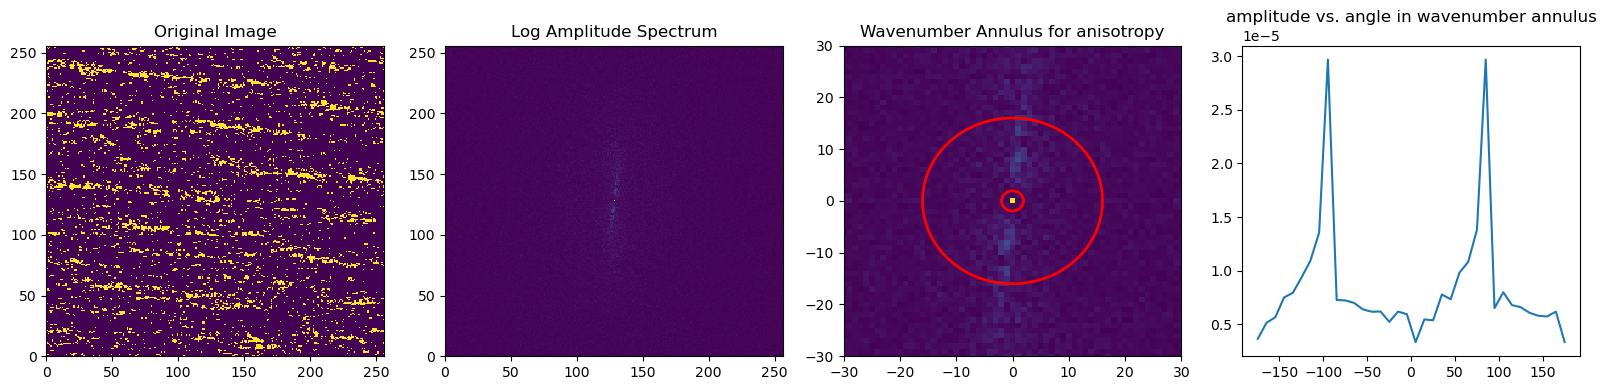

angle (degrees) is  -94.65479471926312 85.34520528073688
varpeak, ainsotropyH is  3.5721456763128696 0.045880979918702894


np.float64(3.5721456763128696)

In [120]:
# Maximum A value case 83,4
calc_anisotropy(83,3)
#calc_anisotropy(96,14)

In [127]:
# Loop to calculate A for all cases and times, put in array As 
NSIM = ds_2D.member.size
NT = ds_2D.time.size
# Anisotropy strength A: make container for results of loop 
As = np.zeros( (NSIM,NT) )

# THE BIG LOOP over ensemble members (simulations)
for mem in range( ds_2D.member.size ):
    for it in range(ds_2D.time.size):   # times 200 minutes apart, not the first two 
        As[mem,it] = calc_anisotropy(mem,it,doplot=False,doprint=False)

In [128]:
As

array([[       nan, 1.44229498, 1.3230944 , ..., 1.79803493, 1.69700411,
        1.69614019],
       [       nan, 1.42282266, 1.25869818, ..., 1.44500382, 1.63686103,
        1.50808933],
       [       nan, 1.28951318, 1.35839407, ..., 1.58164657, 1.51797917,
        1.6500682 ],
       ...,
       [       nan, 1.37990271, 1.36833551, ..., 1.96788074, 1.56109399,
        1.57202675],
       [       nan, 1.53393142, 1.34277699, ..., 1.81605072, 1.53517092,
        1.68459093],
       [       nan, 1.34979291, 1.40225464, ..., 1.39159858, 1.51362691,
        1.55779584]], shape=(103, 18))

# Make small dataset with domain-integral energetics and cloud pattern measures
#### The mesoscale patterns are characterized by nH for the 5km scale, & A

To do this, grab the profiles_all.nc dataset in Box, and add more variables

In [9]:
# Grab "profiles_thermke" dataset (domain means, is its defining characteristic)
# thermo-oriented dataset, I don't need u,v here, anisotropy is from shear but COMPLICADO
ds_profiles = xr.open_dataset('/Users/bmapes/Box/EvolutionaryConvection/CloudBotany/' +\
                              'CloudBotany_profiles_all.nc')
ds_profiles

<xarray.Dataset> Size: 675MB
Dimensions:  (member: 103, time: 720, zm: 175, zt: 175)
Coordinates:
  * member   (member) int32 412B 1 2 3 4 5 6 7 8 ... 96 97 98 99 100 101 102 103
  * time     (time) datetime64[ns] 6kB 2020-02-01T00:05:00 ... 2020-02-03T12:...
  * zm       (zm) float32 700B 0.0 15.0 30.0 ... 6.772e+03 6.854e+03 6.938e+03
  * zt       (zt) float32 700B 7.5 22.5 37.65 ... 6.813e+03 6.896e+03 6.98e+03
Data variables: (12/13)
    wthvt    (member, time, zm) float32 52MB ...
    ql       (member, time, zt) float32 52MB ...
    ql2r     (member, time, zt) float32 52MB ...
    cfrac    (member, time, zt) float32 52MB ...
    w2r      (member, time, zm) float32 52MB ...
    u2r      (member, time, zt) float32 52MB ...
    ...       ...
    thv      (member, time, zt) float32 52MB ...
    rhof     (member, time, zt) float32 52MB ...
    skew     (member, time, zm) float32 52MB ...
    thltend  (member, time, zt) float32 52MB ...
    u        (member, time, zt) float32 52MB ...
    v        (member, time, zt) float32 52MB ...
Attributes:
    Author:   
    Source:   DALES 4.2 git: v4.3-108-gca69cb
    history:  Created on 20220520 at 213340.423
    title:    profiles.001.nc

In [11]:
# Make anomalies (from time mean) and perfurbations (from vertical mean) 

# For clarity, subtract mean to better see anomalies a and perturbations p 
# make temporal anomaly a and then vertical perturbation p to theta-v data variable: 
# thva is diff from time mean or initial, thvap is deviation from vertical mean at each time

ds_profiles['thva']  = ds_profiles['thv']  - ds_profiles['thv'].isel(time=0)
ds_profiles['thvap'] = ds_profiles['thva'] - ds_profiles['thva'].mean(dim='zt')
ds_profiles['rhoa'] = ds_profiles['rhof'] - ds_profiles['rhof'].isel(time=0)

In [116]:
# Add precipitation variables from 2D dataset 

ds_profiles['PR'] = ds_2D.surfprec.mean(dim=['xt','yt'])  # precip rate 
ds_profiles['IP'] = ds_2D.surfprec.mean(dim=['xt','yt']).cumulative_integrate('time','s') 

----------------
# Vertical integrals to evaluate energetics 
### Convection's KE budget, & raison d'etre (mean PE lowering)
### 1. Compute KE generation rate by [w'b'], and KE (mass integrated) 

$ d/dt<[KE]> = <[w * dw/dt]> = <[wb]> = <  w' \cdot \theta_v' > g/ \theta_{v_0}  $ = wthvt *g_over_theta

#### Note: The vertical integral in the whole-domain volume integral should be density weighted <[]>. 

That is just a little complicated because rhof the density is available on the 'zt' levels (f for "full" cell centers) while the fluxes are on interfaces or 'zm' levels. So interpolate rhof to rhom for use in vertical integrals. 

In [50]:
# Interpolate thv and rhof(zt) to rhom(zm) (interface levels from full cell zt levels) 
rhof = ds_profiles.rhof
thv = ds_profiles.thv 
zm = ds_profiles.zm
ds_profiles['rhom'] = rhof.interp(zt=zm, method="linear", kwargs={"fill_value": "extrapolate"})
ds_profiles['thvm'] = thv.interp(zt=zm, method="linear", kwargs={"fill_value": "extrapolate"})

In [56]:
# KE density weighted integrals

# Time integrate (cumulate) the vertical mean KE source from buoyancy flux
# approximately constant theta-v, lazy work since thv is on staggered grid
# g_over_th0 = 9.81/290 naw let's use the right equations even though this was good enough

# Integrate BF = g.thetav * wthv
g_over_thv = 9.8/ds_profiles.wthvt

ds_profiles['BF'] = ( (9.8/ds_profiles.thvm) * (ds_profiles.wthvt*ds_profiles.rhom) ).mean('zm')
ds_profiles['IBF'] = ds_profiles.BF.cumulative_integrate('time','s')
ds_profiles['VKE'] = (ds_profiles.rhom * ds_profiles.w2r).mean('zm')/2
ds_profiles['HKE'] = (ds_profiles.rhof * ds_profiles.HTKE).mean('zt')/2

### 2. Compute PE time evolution, & rad. PE tendency ("forcing") 

$ <[PE']> = \int (gz \rho') dz = \int gz \rho_o (\theta_v'/\theta_{v_0}) dz$ = gz* rhof* (thltend/thl)

I have thv but not thl at hand, close enough, both are near enough plain theta as a mere gentle height-dependence denominator for normalization.

In [26]:
# PE time series, from anomalous density rhoa: units will be J m-2
ds_profiles['PEa'] = 9.8*( (ds_profiles.rhoa)*(ds_profiles.zt) ).integrate('zt')

# Use heating rate to estimate radiative part of that time series
ds_profiles['PEdot_rad'] = -9.8*( (ds_profiles.rhof)*(ds_profiles.zt)   * \
                                 ds_profiles.thltend / ds_profiles.thv ).integrate('zt')

# Time derivative of state variable PE: notice time steps are 5 minutes apart 
# '2020-02-01T00:05:00.000000000', '2020-02-01T00:10:00.000000000',...
ds_profiles['PEadot'] = ds_profiles['PEa'].diff('time') / (5*60)   # units of Wm-2

-------------

## Dataset of horizontal pattern variables H, A every 200 mins</h2>

#### Pattern aspects
H5, Hn5, dHn5, Anis 

#### Candidate predictors and impacts for relationship studies
PR, IP, BF, IBF, w2r or VKE, PEa, PEadot, PEdot_rad

In [163]:
ds_patterns = ds_profiles[['BF','IBF','w2r','VKE','HKE','thvap','thv','PR','IP','PEa','PEadot','PEdot_rad']]\
                .sel(time=ds_2D.time)

In [164]:
# Merge H5km, Hn5km = H/Smax and its time change, Anisotropy A into ds_patterns data set 

oc=3 # Octave 3, 2^3 x 2^3 rebinning, 32x32 boxes remain, 4.8km size

# 200-minute time differences of nH5km
Hn5km = nHs[:,:,oc] # Octave 3, the 32x32 boxes of 4.8km size 
dHn5 = Hn5km * 0.0  # container for 200-minute forward time differences, zero the default
dHn5[:,0:16] = Hn5km[:,1:17] - Hn5km[:,0:16]

# Make a dictionary of coordinates so we can add them to xarray dataset 
var_dictA = {'Anis': (('member', 'time'), np.nan_to_num(As))}
var_dictH = {'H5': (('member', 'time'), Hs[:,:,oc])}
var_dictHn = {'Hn5': (('member', 'time'), Hn5km)}
var_dictdHn = {'dHn5': (('member', 'time'), dHn5)}

ds_patterns = ds_patterns.assign(**var_dictA)
ds_patterns = ds_patterns.assign(**var_dictH)
ds_patterns = ds_patterns.assign(**var_dictHn)
ds_patterns = ds_patterns.assign(**var_dictdHn)


ds_patterns

<xarray.Dataset> Size: 4MB
Dimensions:    (member: 103, time: 18, zm: 175, zt: 175)
Coordinates:
  * member     (member) int32 412B 1 2 3 4 5 6 7 8 ... 97 98 99 100 101 102 103
  * time       (time) datetime64[ns] 144B 2020-02-01T00:05:00 ... 2020-02-03T...
  * zm         (zm) float32 700B 0.0 15.0 30.0 ... 6.772e+03 6.854e+03 6.938e+03
  * zt         (zt) float32 700B 7.5 22.5 37.65 ... 6.813e+03 6.896e+03 6.98e+03
Data variables: (12/16)
    BF         (member, time) float32 7kB -2.071e-06 0.0001047 ... 0.0001509
    IBF        (member, time) float64 15kB 0.0 1.109 2.483 ... 25.81 27.96 29.87
    w2r        (member, time, zm) float32 1MB 0.0 5.471e-05 ... 1.148e-05
    VKE        (member, time) float32 7kB 0.0008108 0.03181 ... 0.05495 0.05462
    HKE        (member, time) float32 7kB 0.001146 0.06079 ... 0.4459 0.3064
    thvap      (member, time, zt) float32 1MB 0.0 0.0 0.0 ... 0.3439 0.3219
    ...         ...
    PEadot     (member, time) float32 7kB nan 2.551 1.737 ... 1.228 2.381 1.846
    PEdot_rad  (member, time) float32 7kB 17.31 17.33 17.31 ... 18.08 17.78
    Anis       (member, time) float64 15kB 0.0 1.442 1.323 ... 1.392 1.514 1.558
    H5         (member, time) float64 15kB 0.0 0.0 0.1258 ... 1.366 1.599 0.8396
    Hn5        (member, time) float64 15kB 0.0 0.0 0.007863 ... 0.09991 0.05248
    dHn5       (member, time) float64 15kB 0.0 0.007863 0.004756 ... 0.0 0.0
Attributes:
    Author:   
    Source:   DALES 4.2 git: v4.3-108-gca69cb
    history:  Created on 20220520 at 213340.423
    title:    profiles.001.nc

In [165]:
# SAVE modest sized ds_patterns dataset for later use without having to recompute 
ds_patterns.to_netcdf('CloudBotany_patterns_predictors.nc')

#'/~/GitHub/EvolutionaryConvection/Shallow_patterns_CloudBotany/CloudBotany_patterns_predictors.nc'

# Does precipitation make PBL overstabilize? 

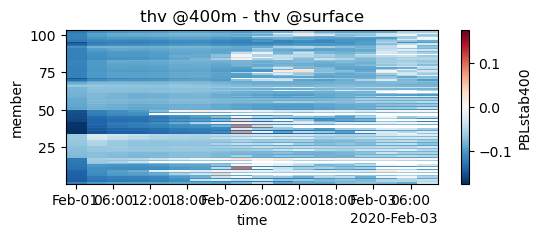

In [237]:
# Lowest 400m stability 
# Lowest 400m stability 
ds_patterns['PBLstab400'] = ds_patterns.thv.sel(zt =400, method='nearest') - \
                            ds_patterns.thv.sel(zt =0  , method='nearest')

ds_patterns['PBLstab400'].plot(size=2, aspect=3); plt.title('thv @400m - thv @surface');

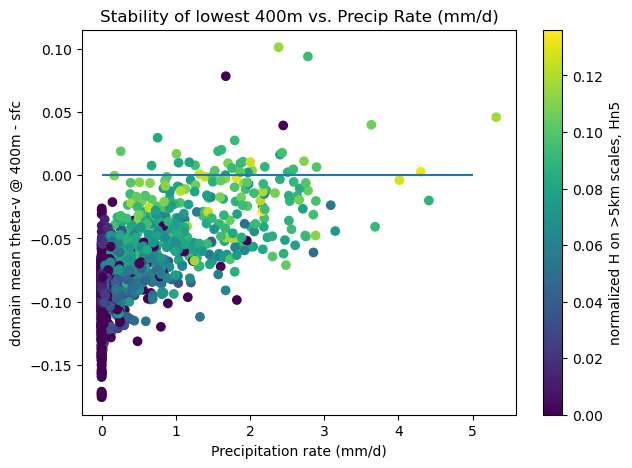

In [238]:
# How does overstability depend on precip 
plt.figure(figsize=(7,5))
plt.scatter(ds_patterns.PR*86400., ds_patterns.PBLstab400, c=ds_patterns.Hn5); 
plt.title('Stability of lowest 400m vs. Precip Rate (mm/d)');
plt.xlabel('Precipitation rate (mm/d)'); plt.ylabel('domain mean theta-v @ 400m - sfc');
plt.hlines(0, 0,5);
plt.colorbar(label='normalized H on >5km scales, Hn5');


# 103 page PDFs of patterns & measures
## Images after this time-height section
### how did I lose this code?? Rewriting

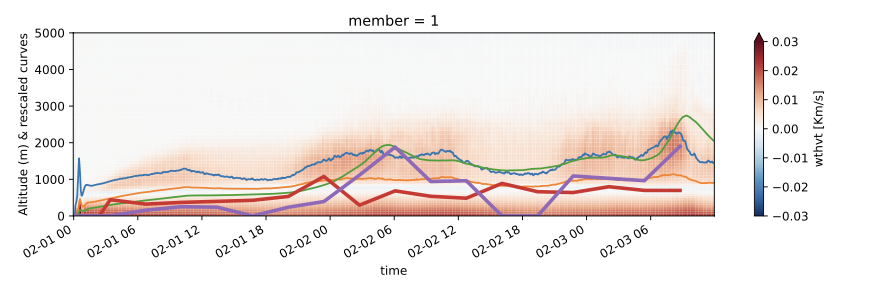

"In the time series, the product wthv is the colored image. Thin curves are kinetic energy budget terms: orange is vertical mean VKE, blue is vertical mean [b’w’] times 600s, and green is HKE/3, all rescaled so that 2000m altitude corresponds to 0.1 J/kg in VKE. Thick curves are pattern measures, only computed every 200 minutes: red is anisotropy 1000*(A-1), purple is 20000 times the normalized pattern information measure Hn for 5km rebinning boxes. "

In [ ]:
# FOR THE PAPER: 103 page PDF of simulations with time series on top 
# Multipage PDF file trick from https://gist.github.com/thanasi/7e08bc41e6a085cd2140
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('AllSimulations.wthv_H5_A_HKE_VKE_9imgs.pdf') as pdf:
    vars = list(ds_patterns.keys())[0:9]
    
    # Index page of all the variables (11 currently, 4x3 has room for 12 
    plt.figure( figsize=(12,16) )
    for i,var in enumerate(vars): 
        plt.subplot(4,3,i+1)
        ds_patterns[var].plot(); plt.title(var)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page
    
    # Loop over members, one page per member. Plot 3 variables, then 9 images (15 panels)
    for imem, member in enumerate(ds_patterns.member):

            plt.figure( figsize=(12,16) )

# top plot: part of a 4,1,1 subplot 
            plt.subplot(4,1,1)
            ds_profiles.wthvt[imem][::3][::3].transpose().plot() # Subsample 3x in time, height 
            plt.ylabel('Altitude (m) & rescaled curves')
            plt.plot(ds_profiles.time, (ds_profiles.BF[imem]  *600.  *(2000/0.1) ))
            plt.plot(ds_profiles.time, (ds_profiles.VKE[imem]        *(2000/0.1) ))
            plt.plot(ds_profiles.time, (ds_profiles.HKE[imem] /3     *(2000/0.1) ))
            plt.plot(ds_patterns.time, ((ds_patterns.Anis[imem]-1)        *1000   ),linewidth=3)
            plt.plot(ds_patterns.time, (ds_patterns.Hn5[imem]             *20000  ),linewidth=3);
        
# Time series of images every 400 minutes
            for it in range( ds_patterns.time.size //2 ): 
                plt.subplot(4,3,4 + it)
                np.sqrt(ds_2D.lwp[imem][it*2+1]).plot.contourf( \
                    cmap='gray', vmin=0, vmax=0.5, levels=[0.2,0.6], add_colorbar=False)
                plt.axis('off')
                plt.title(str(ds_2D.time[it*2+1].values)[0:16]+\
                          ': H,A= '+'{:.2f}'.format( ds_patterns.Hn5[imem][it].values ) + ' , '+\
                                    '{:.2f}'.format( ds_patterns.Anis[imem][it].values) )
                
            plt.tight_layout()
            pdf.savefig()  # saves the current figure into a pdf page


In [ ]:
# OLDER 103 page PDF with 12 panels per page, after an index page 
# Multipage PDF file https://gist.github.com/thanasi/7e08bc41e6a085cd2140
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('AllSimulations.9times.contourf.pdf') as pdf:
    vars = list(ds_patterns.keys())[0:9]
    
    # Index page of all the variables (11 currently, 4x3 has room for 12 
    plt.figure( figsize=(12,16) )
    for i,var in enumerate(vars): 
        plt.subplot(4,3,i+1)
        ds_patterns[var].plot(); plt.title(var)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page
    
    # Loop over members, one page per member. Plot 3 variables, then 9 images (15 panels)
    for imem, member in enumerate(ds_patterns.member):

            plt.figure( figsize=(12,16) )

# top 3 plots
# IBF, IP, Anisotropy rescaled for plot 
            plt.subplot(4,3,1)
            ds_patterns['IBF'][imem].plot()
            (20*ds_patterns['IP'][imem]).plot(); 
            (20*ds_patterns['Anis'][imem]).plot(); 
            plt.ylim([0,50])
            plt.title('IBF,20*IP,10*A, mem ' + str(imem+1))
# Time series of energy budget related quantities, rescaled for plot  
            plt.subplot(4,3,2)

            plt.plot(400*ds_profiles.BF[imem,:]);
            plt.plot(ds_profiles.VKE[imem,:]);
            plt.plot(0.25*ds_profiles.HKE[imem,:]);
            plt.vlines(288,0,0.1)
            plt.vlines(576,0,0.1)
            plt.title('400*BF, VKE, HTKE/4')
            plt.ylim([0,0.2])
        
#            (0.1*(ds_profiles['PEadot'] -ds_profiles['PEdot_rad']))[imem].plot()
#            (10*ds_profiles.w2r)[imem].mean('zm').plot()
#            ds_profiles.HTKE[imem].mean('zt').plot()
#            plt.title('1+(PEdot-PEdotrad)/10, 10*VKE, HTKE')
#            plt.ylim([-2,2.5])

# normalized H spectrum by scales of rebinning (octaves) 
            plt.subplot(4,3,3)
            plt.pcolor(ds_patterns.time, np.log2(octaves), nHs[imem].transpose() )
            plt.colorbar();
            plt.title('pattern H/Smax by scale')
        
# Time series of images every 400 minutes
            for it in range( ds_patterns.time.size //2 ): 
                plt.subplot(4,3,4 + it)
                np.sqrt(ds_2D.lwp[imem][it*2+1]).plot.contourf( \
                    cmap='gray', vmin=0, vmax=0.5, levels=[0.2,0.6], add_colorbar=False)
                plt.axis('off')
                plt.title(str(ds_2D.time[it*2+1].values)[0:16]+\
                          ': H,A= '+'{:.2f}'.format( ds_patterns.Hn5[imem][it].values ) + ' , '+\
                                    '{:.2f}'.format( ds_patterns.Anis[imem][it].values) )
                
            plt.tight_layout()
            pdf.savefig()  # saves the current figure into a pdf page


## A 103 page view of time-height sections of a few fields 

In [13]:
# Make profile t-z plots in AllSimulations.time-heights.pdf : a dataset overview 

from matplotlib.backends.backend_pdf import PdfPages

vars = list(ds_profiles.keys()) 
vars = ['wthvt','thva','ql','w2r','HTKE'] # 5 variables and then skew 

#with PdfPages('/Users/bmapes/Box/EvolutionaryConvection/CloudBotany/AllSimulations.time-heights.pdf') as pdf:
with PdfPages('AllSims.time-heights.pdf') as pdf:

    for imem,mem in enumerate(ds_profiles.member):    
        # All 5 variables above 
        plt.figure( figsize=(10,14) )
        for i,var in enumerate(vars): 
            plt.subplot(6,1,i+1)
            ds_profiles[var][imem][::3][::3].transpose().plot() # Subsample 3x in time, height 
            # plt.ylim([0,5000])
            plt.title( var + ', member= '+str(imem+1) )
            
#skew: clip colors 
        plt.subplot(6,1,6)
        ds_profiles['skew'][imem][::3][::3].transpose().plot(vmax=3) # fixed colorbar for skew 
        plt.ylim([0,5000])
        plt.title( 'skew' + ', member= '+str(imem+1) )
        plt.tight_layout()
        pdf.savefig()
        plt.close()

In [ ]:
        # one page of above, here in in notebook 
        imem = 83
        plt.figure( figsize=(10,14) )
        for i,var in enumerate(vars): 
            plt.subplot(6,1,i+1)
            ds_profiles[var][imem][::3][::3].transpose().plot() # Subsample 3x in time, height 
            plt.title( var + ', member= '+str(imem+1) )
            
#skew: clip colors 
        plt.subplot(6,1,6)
        ds_profiles['skew'][imem][::3][::3].transpose().plot(vmax=3) # fixed colorbar for skew 
        plt.ylim([0,5000])
        plt.title( 'skew' + ', member= '+str(imem+1) )

## Energetics ideas of BF --> VKE --> HKE

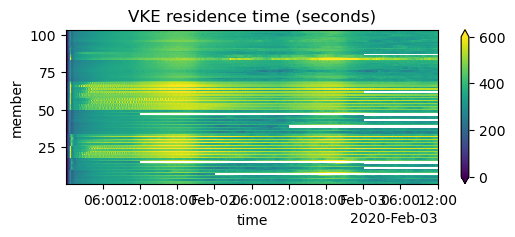

In [92]:
### Compute vertically averaged 'KE efficiency' measures 
# residence time of w'w' = <w2r>/<wthvt>
tau = ds_profiles.VKE / ds_profiles.BF

tau.plot(size=2,aspect=3,vmin=0,vmax=600); plt.title("VKE residence time (seconds)");

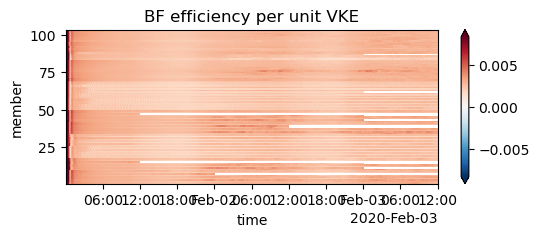

In [98]:
# The inverse of tau is sort of an efficiency, thv flux per unit w'w' 

(1.0/tau).plot(size=2,aspect=3, vmax=1./120.); plt.title("BF efficiency per unit VKE");

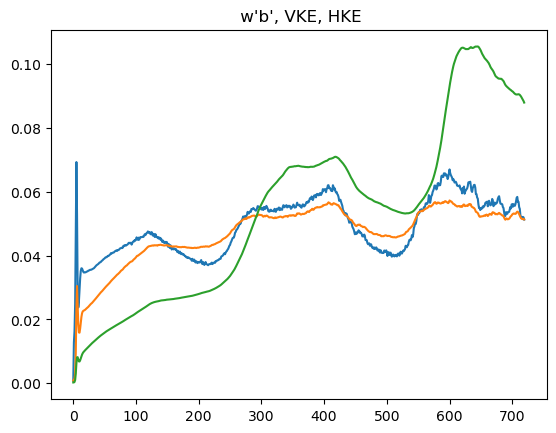

In [101]:
# BF, VKE, HKE 

imem=80
plt.plot(400*ds_profiles.BF[imem,:]); plt.title(" w'b', VKE, HKE") 
plt.plot(ds_profiles.VKE[imem,:]);
plt.plot(0.25*ds_profiles.HKE[imem,:]);

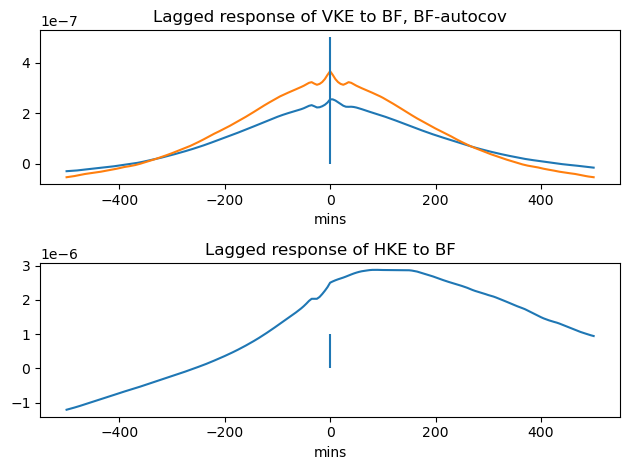

In [104]:
# Lagged covariance between BF and VKE, HKE

lags = np.linspace(-100,100,201)  # time lags in 5 minute increments 
lag_covH=[] # container for result, list type not ideal
lag_covV=[] # container for result
auto_BF =[] # container for result

for ilag,lag in enumerate(lags): 
    
    auto_BF.append ( xr.cov(ds_profiles.BF, ds_profiles.BF.shift(time=-int(lag)), dim='time').values )
    lag_covH.append ( xr.cov(ds_profiles.BF, ds_profiles.HKE.shift(time=-int(lag)), dim='time').values )
    lag_covV.append ( xr.cov(ds_profiles.BF, ds_profiles.VKE.shift(time=-int(lag)), dim='time').values )

lag_covV = np.array(lag_covV)
lag_covH = np.array(lag_covH)
auto_BF = np.array(auto_BF)

imem=85
plt.subplot(211)
plt.plot(lags*5, lag_covV[:,imem]); plt.xlabel('mins'); plt.title('Lagged response of VKE to BF, BF-autocov');
plt.plot(lags*5, auto_BF[:,imem] *500); plt.xlabel('mins')
plt.vlines(0,ymin=0,ymax=0.5e-6);

plt.subplot(212)
plt.plot(lags*5, lag_covH[:,imem]); plt.xlabel('mins'); plt.title('Lagged response of HKE to BF');
plt.vlines(0,ymin=0,ymax=1e-6);
plt.tight_layout()

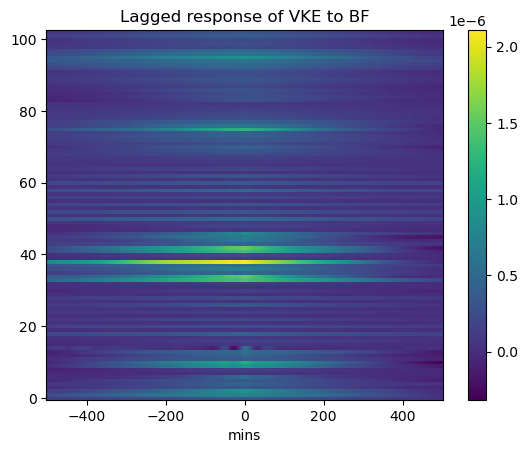

In [32]:
plt.pcolor(lags*5, range(103), np.transpose(lag_covV)); plt.colorbar()
plt.xlabel('lag in mins'); plt.title('Lagged response of VKE to BF');

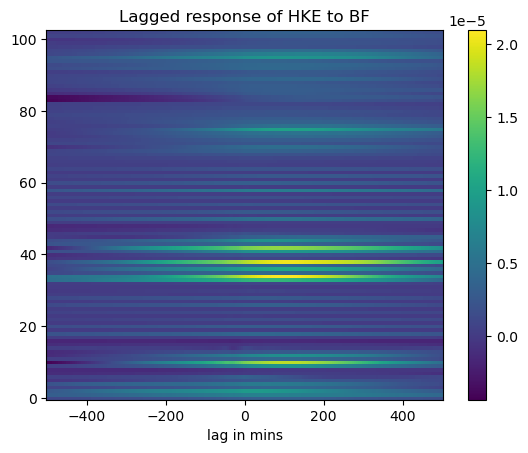

In [106]:
plt.pcolor(lags*5, range(103), np.transpose(lag_covH)); plt.colorbar()
plt.xlabel('lag in mins'); plt.title('Lagged response of HKE to BF');

# Potential energy figgerings 
## disappointing and confusing

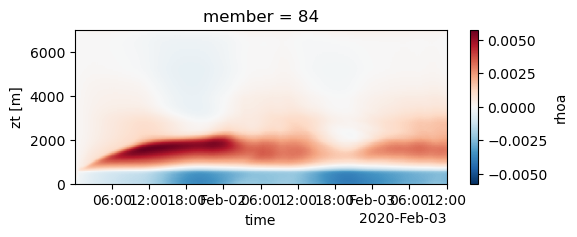

In [31]:
# PE-related plots of anomalous density from initial state. 
# Heavy over light develops, is initial profila a relevant reference? 
imem=83
ds_profiles.rhoa[imem,:,:].transpose().plot(size=2,aspect=3); 

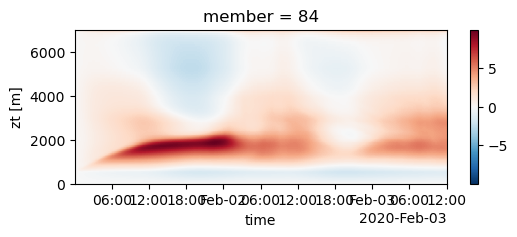

In [35]:
# Z-weighted density profile differences, a potential energy
# It seems to increase with time, naive PE thinking is failing me here 
((ds_profiles.rhoa)*(ds_profiles.zt))[imem].transpose().plot(size=2,aspect=3); 

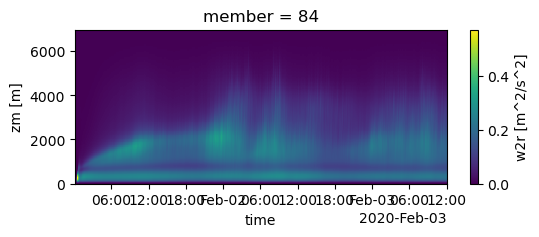

In [36]:
(ds_profiles.w2r)[83,1:,:].transpose().plot(size=2,aspect=3); 

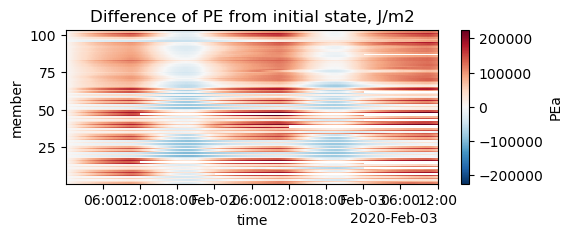

In [109]:
ds_profiles['PEa'].plot(size=2,aspect=3); 
plt.title('Difference of PE from initial state, J/m2');

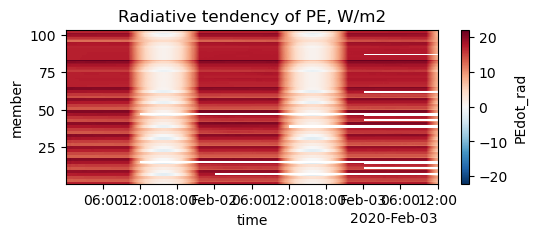

In [110]:
ds_profiles['PEdot_rad'].plot(size=2,aspect=3); 
plt.title('Radiative tendency of PE, W/m2');

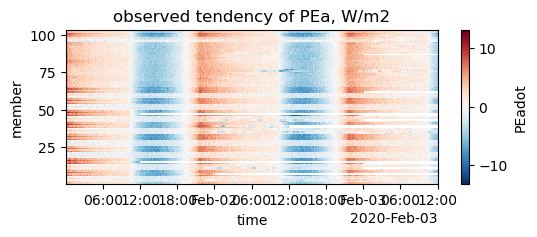

In [111]:
ds_profiles['PEadot'].plot(size=2,aspect=3); 
plt.title('observed tendency of PEa, W/m2');

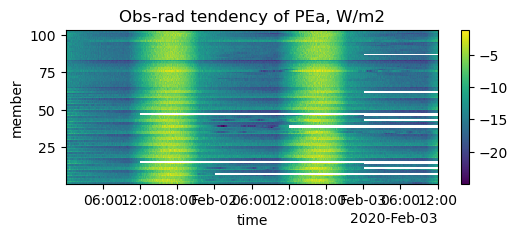

In [112]:
(ds_profiles['PEadot'] -ds_profiles['PEdot_rad']).plot(size=2,aspect=3); 
plt.title('Obs-rad tendency of PEa, W/m2');

# Not utilized here: composite structure 

Another approach to anisotropy, etc. 

----------- 
<h2 id="Composite_prob">Composite of probability around all nonzero values</h2>


In [ ]:
        # test for a given imem, it 
        it=3
        imem=83
        sq = ds_2D.lwp[imem][it]
        
# create 'active' and 'p_active' arrays: 1 for top 10% of LWP, all others 0
        decile9 = np.sort( np.ravel( sq.values) )[9*sq.size//10]   # 9/10 decile 
        active = (sq > decile9)
        p_active = active/np.sum(active) # probability, because it sums to 1

        comp = composite_around_nonzeros_periodic(p_active)

In [ ]:
# THE BIG LOOP over ensemble members (simulations)
#for mem in range( ds_2D.member.size ):
#    print('simulation ',mem)
#   for it in range(2,18):   # times 200 minutes apart, not the first two 
# as in cell above but not needed  

In [ ]:
        comp.plot( vmax = 2./256./256. )  # max value is always 10/256./256. at the center 

<h2 id="CompProbFits">Claude.ai fits of composite p(r), p(theta)</h2>

In [ ]:
from scipy.optimize import curve_fit

def cartesian_to_polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def fourier_series(x, *a):
    ret = a[0]
    for deg in range(1, len(a)):
        ret += a[deg] * np.cos(deg * x)
    return ret

def fit_polar_curves(data_array, min_radius=0, max_radius=50, poly_degree=6, fourier_terms=6):
    center = np.array(data_array.shape) // 2
    y, x = np.ogrid[-center[0]:center[0], -center[1]:center[1]]
    r, theta = cartesian_to_polar(x, y)
    
    mask = (r >= min_radius) & (r <= max_radius)
    
    r_bins = np.arange(min_radius, max_radius + 1)
    hist, bin_edges = np.histogram(r, bins=r_bins, weights=data_array.values)
    bin_areas = np.pi * (bin_edges[1:]**2 - bin_edges[:-1]**2)
    p_r = hist / bin_areas
    p_r /= p_r.sum()
    
    r_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    p_r_coeffs = np.polyfit(r_centers, p_r, poly_degree)
    p_r_fit = np.poly1d(p_r_coeffs)(r_centers)
    p_r_fit = np.maximum(p_r_fit, 0)
    p_r_fit /= p_r_fit.sum()
    
    theta_bins = np.linspace(-np.pi, np.pi, 60)
    p_theta, _ = np.histogram(theta[mask], bins=theta_bins, weights=data_array.values[mask])
    p_theta /= p_theta.sum()
    
    theta_centers = (theta_bins[:-1] + theta_bins[1:]) / 2
    initial_guess = [1.0] + [0.1] * (fourier_terms - 1)
    popt, _ = curve_fit(fourier_series, theta_centers, p_theta, p0=initial_guess)
    p_theta_fit = fourier_series(theta_centers, *popt)
    p_theta_fit = np.maximum(p_theta_fit, 0)
    p_theta_fit /= p_theta_fit.sum()
    
    p_r_xr = xr.DataArray(p_r_fit, coords=[('r', r_centers)], name='p(r)')
    p_theta_xr = xr.DataArray(p_theta_fit, coords=[('theta', theta_centers)], name='p(theta)')
    
    return p_r_xr, p_theta_xr, p_r, p_theta

def fit_and_plot_polar_curves(data_array, min_radius=10, max_radius=50, poly_degree=6, fourier_terms=12):
    p_r_fit, p_theta_fit, p_r_hist, p_theta_hist = fit_polar_curves(data_array, min_radius, max_radius, poly_degree, fourier_terms)
    
    r_centers = p_r_fit.r.values
    theta_centers = p_theta_fit.theta.values
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1.step(r_centers, p_r_hist, where='mid', label='Histogram', alpha=0.7)
    p_r_fit.plot(ax=ax1, label='Fitted Curve')
    ax1.set_title('p(r)')
    ax1.set_xlabel('r')
    ax1.set_xlim(min_radius, max_radius)
    ax1.legend()
    
    ax2.step(theta_centers, p_theta_hist, where='mid', label='Histogram', alpha=0.7)
    p_theta_fit.plot(ax=ax2, label='Fitted Curve')
    ax2.set_title('p(θ)')
    ax2.set_xlabel('θ')
    ax2.set_xlim(-np.pi, np.pi)
    ax2.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
    ax2.set_xticklabels(['-π', '-π/2', '0', 'π/2', 'π'])
    ax2.legend()
    
    plt.tight_layout()
    plt.show()
    
    return p_r_fit, p_theta_fit

# Assuming your original data is in an xarray DataArray called 'data'
p_r, p_theta = fit_and_plot_polar_curves(comp, min_radius=0, max_radius=50, \
                                         poly_degree=6, fourier_terms=12)